# Проект определение возраста покупателей

***Цель проекта***

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Задачи у модели две:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.



## Исследовательский анализ данных


Проведем исследовательский анализ данных:
- oпределим размер выборки, 
- построим график распределения возраста в выборке,
- напечатаем на экране 16 фотографий и посмотрим, как устроен датасет,
- подведем итог исследовательской части.

### Импорты библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# откроем файл с выборкой
labels = pd.read_csv('/datasets/faces/labels.csv')

### Определение размера выборки

In [3]:
# получим общую информацию
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# откроем 10 случайных строк датафрейма
labels.sample(10)

,file_name,real_age
5516,005516.jpg,20
4822,004822.jpg,43
6080,006083.jpg,33
4522,004522.jpg,24
5614,005614.jpg,76
1095,001095.jpg,25
7585,007607.jpg,10
3842,003842.jpg,14
748,000748.jpg,35
2360,002360.jpg,46


### Построение графика распрелделения возраста в выборке

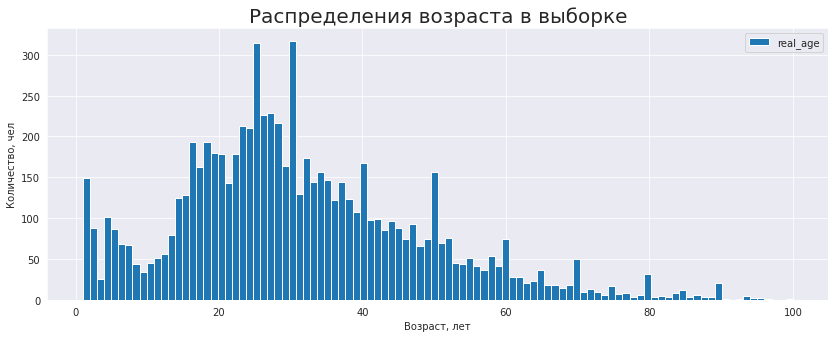

In [5]:
# построим график распределения возраста людей в нашей выборке
sns.set_style("dark")
labels.plot(kind='hist',figsize=(14,5),bins=100, grid=True)
plt.title('Распределения возраста в выборке', fontsize=20)
plt.xlabel('Возраст, лет')
plt.ylabel('Количество, чел')
plt.show()

### Получение образцов фото

In [6]:
# подключим динамическую загрузку данных, используя загрузчик ImageDataGenerator 
datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# чтобы загрузчик извлёк данные из папки, вызовем функцию flow_from_dataframe
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


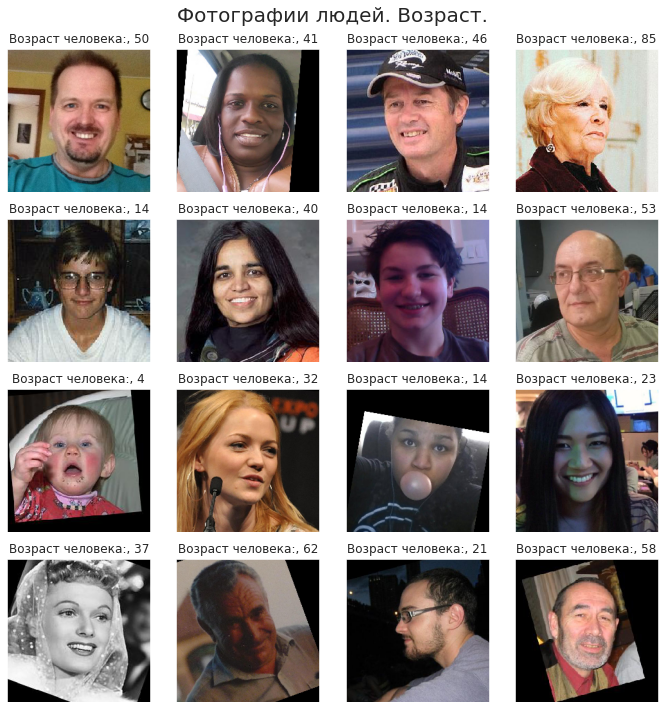

In [8]:
# рассмотрим 16 фотографий из выборки
features, target = next(gen_flow)
fig = plt.figure(figsize=(10,10))
fig.suptitle("Фотографии людей. Возраст.", fontsize=20)
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст человека:, {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

### Вывод об исследовательской части проекта
Для обучения модели мы получили выборку размером 7591 фото и столбец с информацией о реальном возрасте людей. Фотографии, в основном, представляют собой крупные планы лица. Данные в выборке распределены нормально, большинство людей в возрастном диапазоне 18-50 лет, что является положительным моментом - это категория с наибольшей покупательной активностью.

## Обучение нейронной сети 

Так как код в этом разделе запускается в отдельном GPU-тренажёре, поэтому он будет оформлен не как ячейка с кодом, а как код в текстовой ячейке. Для построяние нейросети создадим 4 функции: load_train, load_test, create_model, train_model. Функцией потерь установим MSE - нейронные сети с функцией потерь MSE обучаются быстрее, метрикой качества - MAE. 

```python
# 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model >

```

### Pезультат вывода модели на экран.

```

# rain for 178 steps, validate for 60 steps
Epoch 1/50
2023-06-23 12:11:33.841641: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-23 12:11:34.135595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 58s - loss: 243.5508 - mae: 11.1644 - val_loss: 740.8940 - val_mae: 22.2828
Epoch 2/50
178/178 - 47s - loss: 86.4777 - mae: 7.0085 - val_loss: 495.3293 - val_mae: 17.0573
Epoch 3/50
178/178 - 46s - loss: 56.6399 - mae: 5.6803 - val_loss: 255.6844 - val_mae: 12.7823
Epoch 4/50
178/178 - 46s - loss: 44.1103 - mae: 5.0936 - val_loss: 109.9495 - val_mae: 8.0476
Epoch 5/50
178/178 - 46s - loss: 36.0866 - mae: 4.6059 - val_loss: 85.5391 - val_mae: 7.0062
Epoch 6/50
178/178 - 46s - loss: 27.6748 - mae: 4.0224 - val_loss: 85.3311 - val_mae: 6.7767
Epoch 7/50
178/178 - 47s - loss: 23.6859 - mae: 3.7211 - val_loss: 86.5987 - val_mae: 7.1857
Epoch 8/50
178/178 - 46s - loss: 18.0539 - mae: 3.2555 - val_loss: 72.6535 - val_mae: 6.2854
Epoch 9/50
178/178 - 46s - loss: 15.1865 - mae: 2.9722 - val_loss: 71.0872 - val_mae: 6.1836
Epoch 10/50
178/178 - 46s - loss: 12.9927 - mae: 2.7474 - val_loss: 66.2558 - val_mae: 6.1290
Epoch 11/50
178/178 - 46s - loss: 11.0211 - mae: 2.5053 - val_loss: 70.9604 - val_mae: 6.3314
Epoch 12/50
178/178 - 46s - loss: 9.7705 - mae: 2.3713 - val_loss: 66.1699 - val_mae: 5.8842
Epoch 13/50
178/178 - 47s - loss: 8.9065 - mae: 2.2600 - val_loss: 68.1577 - val_mae: 6.1199
Epoch 14/50
178/178 - 46s - loss: 8.4524 - mae: 2.2209 - val_loss: 58.6690 - val_mae: 5.6813
Epoch 15/50
178/178 - 46s - loss: 8.6491 - mae: 2.2188 - val_loss: 72.5063 - val_mae: 6.5948
Epoch 16/50
178/178 - 46s - loss: 8.6631 - mae: 2.2461 - val_loss: 61.3253 - val_mae: 5.8062
Epoch 17/50
178/178 - 47s - loss: 8.8510 - mae: 2.2414 - val_loss: 67.9180 - val_mae: 6.1835
Epoch 18/50
178/178 - 46s - loss: 8.4918 - mae: 2.2111 - val_loss: 64.3075 - val_mae: 5.8667
Epoch 19/50
178/178 - 46s - loss: 8.5754 - mae: 2.2038 - val_loss: 71.1698 - val_mae: 6.0322
Epoch 20/50
178/178 - 46s - loss: 8.7542 - mae: 2.2494 - val_loss: 66.9816 - val_mae: 5.9923
Epoch 21/50
178/178 - 48s - loss: 8.5247 - mae: 2.2387 - val_loss: 60.4586 - val_mae: 5.7217
Epoch 22/50
178/178 - 46s - loss: 8.1225 - mae: 2.1611 - val_loss: 64.5272 - val_mae: 5.7504
Epoch 23/50
178/178 - 47s - loss: 8.6476 - mae: 2.2077 - val_loss: 60.7095 - val_mae: 5.8258
Epoch 24/50
178/178 - 46s - loss: 9.5360 - mae: 2.3137 - val_loss: 70.8467 - val_mae: 6.3597
Epoch 25/50
178/178 - 49s - loss: 9.5713 - mae: 2.3526 - val_loss: 101.7318 - val_mae: 7.3116
Epoch 26/50
178/178 - 46s - loss: 8.9303 - mae: 2.2547 - val_loss: 60.3334 - val_mae: 5.6638
Epoch 27/50
178/178 - 47s - loss: 8.8012 - mae: 2.2626 - val_loss: 65.3681 - val_mae: 6.0171
Epoch 28/50
178/178 - 47s - loss: 7.7336 - mae: 2.0954 - val_loss: 63.8410 - val_mae: 5.9727
Epoch 29/50
178/178 - 46s - loss: 7.4022 - mae: 2.0347 - val_loss: 77.8402 - val_mae: 6.1073
Epoch 30/50
178/178 - 49s - loss: 15.4258 - mae: 2.6321 - val_loss: 142.4140 - val_mae: 9.2007
Epoch 31/50
178/178 - 48s - loss: 38.7439 - mae: 4.6548 - val_loss: 91.4155 - val_mae: 7.2764
Epoch 32/50
178/178 - 49s - loss: 19.3227 - mae: 3.3060 - val_loss: 67.2236 - val_mae: 6.1140
Epoch 33/50
178/178 - 53s - loss: 10.9628 - mae: 2.5168 - val_loss: 65.6617 - val_mae: 6.0956
Epoch 34/50
178/178 - 51s - loss: 6.2566 - mae: 1.8720 - val_loss: 56.7059 - val_mae: 5.5991
Epoch 35/50
178/178 - 49s - loss: 3.9563 - mae: 1.4883 - val_loss: 55.5482 - val_mae: 5.5100
Epoch 36/50
178/178 - 48s - loss: 3.6010 - mae: 1.3983 - val_loss: 53.8933 - val_mae: 5.4476
Epoch 37/50
178/178 - 49s - loss: 2.6928 - mae: 1.2174 - val_loss: 58.2112 - val_mae: 5.6870
Epoch 38/50
178/178 - 48s - loss: 2.2054 - mae: 1.1096 - val_loss: 53.5974 - val_mae: 5.4238
Epoch 39/50
178/178 - 48s - loss: 1.9992 - mae: 1.0596 - val_loss: 55.8643 - val_mae: 5.5306
Epoch 40/50
178/178 - 48s - loss: 2.1677 - mae: 1.0921 - val_loss: 58.5886 - val_mae: 5.7187
Epoch 41/50
178/178 - 48s - loss: 2.1891 - mae: 1.1099 - val_loss: 54.6730 - val_mae: 5.4881
Epoch 42/50
178/178 - 46s - loss: 2.1780 - mae: 1.1026 - val_loss: 55.2950 - val_mae: 5.4603
Epoch 43/50
178/178 - 46s - loss: 2.6077 - mae: 1.2140 - val_loss: 55.5667 - val_mae: 5.4418
Epoch 44/50
178/178 - 46s - loss: 2.9827 - mae: 1.2901 - val_loss: 59.3819 - val_mae: 5.7657
Epoch 45/50
178/178 - 46s - loss: 3.5306 - mae: 1.4042 - val_loss: 58.2565 - val_mae: 5.6657
Epoch 46/50
178/178 - 46s - loss: 4.4770 - mae: 1.5926 - val_loss: 59.9734 - val_mae: 5.8202
Epoch 47/50
178/178 - 47s - loss: 5.2056 - mae: 1.7169 - val_loss: 64.0365 - val_mae: 5.8206
Epoch 48/50
178/178 - 49s - loss: 5.8540 - mae: 1.8139 - val_loss: 68.2119 - val_mae: 5.9782
Epoch 49/50
178/178 - 50s - loss: 6.5010 - mae: 1.9246 - val_loss: 70.5585 - val_mae: 6.3267
Epoch 50/50
178/178 - 47s - loss: 6.0775 - mae: 1.8767 - val_loss: 65.6773 - val_mae: 5.8141
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 65.6773 - mae: 5.8141
Test MAE: 5.8141
```

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Модель обучена и преодолела планку требуемой точности </div>

## Анализ обученной модели

Для построения неройнной сети мы использовали ***ResNet50*** - модель обучена на более чем 1 миллионе изображений из базы данных ImageNet. ResNet50 способна классифицировать до 1000 объектов. 

***Архитектура свёрточной нейронной сети:***

1. Мы задали модели класс Sequential класс применяется для моделей, в которых слои идут последовательно. 
2. Добавляем слой ResNet50 (чтобы код выполнялся быстрее, мы загрузили предобученные веса указав их в аргументе weights). Используем заморозку указав параметр include_top=False, это позволит избавиться от переобучения и повысить скорость обучения сети.
3. Добавляем слой GlobalAveragePooling2D - пулинг с окном во весь тензор, чтобы усреднить информацию по всему изображению. 
4. Добавляем слой Dense - обычный плотно связанный слой с активацией нейронов ReLU.
5. Оптимизируем параметры при помощи оптимизатора Adam.

При обучении модели мы добились значение MAE 5,81 на тестовой выборке, что вполне приемлемо для решенияя первой задачи нашей нейронной сети. Ошибка в 5,8 лет для рекомендательной системы допустима. Чего не скажешь о второй задаче, продажа алкоголя с ошибкой почти на 6 лет может привести к огромному штрафу для предприятия.
